In [ ]:
# don't wrap long output lines, instead give us horizontal scroll
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

# The Basics

## Getting SCIP and PySCIPOpt

* A simple way is to use a docker container (where we are right now)
* Instructions: http://www.pokutta.com/blog/pages/scip/scip-teaching.html
* Alternatively, you can
    * download and install the SCIP Optimization Suite (https://scipopt.org/index.php#download)
    * install PySCIPOpt (https://github.com/SCIP-Interfaces/PySCIPOpt/blob/master/INSTALL.md)

## Basic usage of PySCIPOpt

* We need to import PySCIPOpt
* Everything happens inside a `Model` object
* Use `help` to get help
* To redirect SCIPs output to Jupyter use `redirectOutput`

In [ ]:
from pyscipopt import Model

model = Model()

# By default, SCIPs output is printed in the std output, not visible here. To fix this:
model.redirectOutput()
model.printVersion()


# to get help on function, e.g., addVar
help(model.addVar)

In [ ]:
# This creates a continuous variable call cvar between 0.1 and 2.0
cvar = model.addVar("cvar", lb = 0.1, ub = 2.0)

# This create a binary variable
bvar = model.addVar("bvar", vtype = 'B')


In [ ]:
# We can combine variables to create expressions, which we can use to create constraints
print(cvar + 2*bvar)
print("--------------------")

print(cvar + 2*bvar <= 1)
print("--------------------")

# to add a constraint:
cons1 = model.addCons(cvar + 2*bvar <= 1, "my cons")

In [ ]:
# now we just need an objective function and we can optimize
model.setObjective(cvar + bvar, "maximize")
model.optimize()


# As cons1 forces bvar to be 0, we expect cvar = 1 and bvar = 0; let us verify

print("\nBest Solution:")
model.printBestSol()

In [ ]:
# to access solution values
sol = model.getBestSol()
print( sol[cvar] == 1.0 and sol[bvar] == 0.0 )

# one can also evaluate expressions
model.getSolVal(sol, (cvar + 1)**2 + bvar)


In [ ]:
# we can write the model we just created to a file:
model.writeProblem("model.lp")
# in different formats
print("----------------------")
model.writeProblem("model.cip")

In [ ]:
# We forgot to add a variable and a (nonlinear) constraint, let us add it.
# First, we need to free the transformed problem
model.freeTransform()


t = model.addVar("objective", ub = None) # in 0, infinity
model.addCons(cvar + 1.0 / cvar <= t, "forgotten_constraint")
model.setObjective(t, "minimize")
model.writeProblem("model.cip")

print("------------------------")
model.optimize()

**Note:** In this simple example we added the variables individually to create the sum expression which is fine because the example is small and the number of variables is fixed. For creating useful models often loops are involved and the quicksum function is the best way to create such expressions.

See the sudoku example for reference: https://scip-interfaces.github.io/PySCIPOpt/docs/html/sudoku_8py_source.html



# TSP exercise


We will solve some of the tsp instances located at `tspdata/` with PySCIPOpt

In [ ]:
from pyscipopt import Model, Heur, Eventhdlr, Conshdlr, quicksum, SCIP_RESULT, SCIP_EVENTTYPE, SCIP_HEURTIMING

## Reading the instance and Generating the graph

* The format of the instances is as follows 
```
HEADER_INFO
...
1 x1 y1
.
.
.
n xn yn
END
```
* We write a function that reads the instance name and returns three dictionaries:
`x` mapping each vertex to its $x$ coordinate 
`y` mapping each vertex to its $y$ coordinate
`xy` mapping each vertex to a tuple of its coordinates ($x$, $y$), which we are going to use for plotting

In [ ]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    

def read_instance(name):
    x ={}
    y ={}
    xy = {}
    with open(name) as fp:
        line = fp.readline()
        cnt = 1
        while line:
            sp = line.split()
            if len(sp) > 0 and sp[0].isnumeric():
                assert len(sp) == 3
                assert is_number(sp[1]) and is_number(sp[2])
                x[cnt] = float(sp[1])
                y[cnt] = float(sp[2])

                # dictionary from node to its coordinates: we use this for plotting the graph
                xy[cnt] = (x[cnt], y[cnt])
                cnt += 1
            line = fp.readline()
    return x, y, xy

* $n$ is the number of nodes (length of `x`)
* $V= \{1,\ldots, n\}$ are going to be the nodes
* We write a function that given `x` and `y` dictionaries between vertices and their coordinates, returns a dictionary `c` between pairs of vertices and their distance.

In [ ]:
import math

def distance(x1,y1,x2,y2):
    """distance: euclidean distance between (x1,y1) and (x2,y2)"""
    return round(math.sqrt((x2-x1)**2 + (y2-y1)**2),2)

def compute_distance_matrix(x,y):
    n = len(x)
    V = range(1,n)
    c={}
    for i in V:
        for j in V:
            if j > i:
                c[i,j] = distance(x[i],y[i],x[j],y[j])
    return c

## Visualizing the graph of an instance

In [ ]:
pip install networkx

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [ ]:
import networkx
import matplotlib.pyplot as plt

# read instance
x, y, xy = read_instance('tspdata/burma14.tsp')
V = range(1, len(x))

# make plot look nicer
plt.figure(figsize=(10,6), dpi=100) 

# define empty graph
graph = networkx.Graph()

# the graph is complete so there are edges between every pair of nodes
edgelist = [(i,j) for i in V for j in V if j > i]

# add edges
graph.add_edges_from(edgelist)

# draw the graph, place the nodes using x,y coordinates
networkx.draw(graph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

# show plot
plt.show()

## Tasks
In these exercise we are going to solve TSP problems as the one visualized above.
Below we will discuss the constraint integer program model of the TSP that we will solve.
To solve it, we will need a `constraint handler`.
On top of that, we will also implement the [2 Opt Heuristic](https://en.wikipedia.org/wiki/2-opt) and an `event handler` to visualize every solution that SCIP finds.

Before discussing the TSP model, we provide the skeleton code for implementing the `event handler` and the `heuristic`. Later you will find these classes again and you will have to implement them.

In [ ]:
# (dummy) Event handler
class NewSolEvent(Eventhdlr):

    # we pass some information we need the event handler to know, like the variables
    # and the positions of the nodes
    def __init__(self, vars_dict, coords_nodes):
        self.data = {}
        self.data['vars'] = vars_dict
        self.data['xy'] = coords_nodes

    # initialization method: here we tell SCIP that we want to listen to the BESTSOLFOUND event,
    # that is, we want to be called whenever a new best solution is found
    def eventinit(self):
        self.model.catchEvent(SCIP_EVENTTYPE.BESTSOLFOUND, self)

    # here we stop listening to the event we were listening to
    def eventexit(self):
        self.model.dropEvent(SCIP_EVENTTYPE.BESTSOLFOUND, self)

    # execution method of the event handler
    def eventexec(self, event):
        print("EVENT: new best sol found. TODO: visualize the solution")
        pass


# (dummy) Heuristic 
class TwoOpt(Heur):

    # we pass some information we need the heuristic to know, like the variables
    # and the costs of the edges
    def __init__(self, costs, vars_dict):
        self.data = {}
        self.data['costs'] = costs
        self.data['vars'] = vars_dict
        self.data['primalbound'] = -1.0

    # execution method of the heuristic. 
    
    def heurexec(self, heurtiming, nodeinfeasible):
        
        # 2 Opt is an improving heuristic and so it should run only
        # once per new solution. To realize if we should run, that is, if there is a solution and this solution is 
        # different from the time we were called, we store the primal bound of the last solution we saw.
        # NOTE: it would be easier to just ask whether the solutions are the same, however, this does not work
        # with the current state of PySCIPOpt.
        
        # get primal bound
        primalbound = self.model.getPrimalbound()
        
        # if we have no solution yet don't run
        if self.model.isInfinity(primalbound):
            return {"result": SCIP_RESULT.DIDNOTRUN}
        
        # if we already saw this solution do not run
        if primalbound == self.data['primalbound']:
            return {"result": SCIP_RESULT.DIDNOTRUN}
        
        # remember the new primal bound we are seeing
        self.data['primalbound'] = primalbound
        
        print("HEURISTIC: we should try to improve the solution with 2-opt")
        return {"result": SCIP_RESULT.DIDNOTFIND}

## A TSP Model

We use the standard DFJ formulation: Let $x_{ij} \in \{0,1\}$ represent if the tour uses the edge $(i,j)$ (i.e. if we go from city $i$ to $j$ or the other way around),
then an optimal tour can be found by solving:
$$
\min \sum_{i,j \in V} c_{ij} x_{ij}
$$

subject to:

* We have to enter and leave every city: 
$$
\sum_{i \in V} x_{ij} = 2 \quad \forall j \in V
$$


* No subtours (subtour elimination constraints)

$$
\sum_{i,j \in S} x_{ij} \leq |S| - 1 \quad \forall S \subsetneq V,\ |S| \geq 2
$$


There are too many subtour elimination constraints, so instead of adding them all, we will define a new constraint type $SE((x_{ij})_{i,j\in V})$ which means that the subgraph induced by the $x_{ij}$ has no subtours.

**Note:** In the lecture you saw the subtour elimination constrains written as 
$$
\sum_{e \in \delta(S)} x_{e} \geq 2 \quad \forall S \subsetneq V,\ S \neq \emptyset.
$$
These generate the same model. The advantage of the above way of writting the inequalities is that it motivates the following separation procedure for the subtour elimination constriants. Given a point $\bar x$ one can decide whether there is a subtour elimination constraint by computing the minimum cut of the graph where each edge has weight $\bar{x}_e$. However, in this exercise we will follow a simpler (but less effective) approach by only separating integer valued violated points (see below).


### The SE constraint handler

This constraint type does not exist in SCIP, so your task is to implement it.
The raison d'être of a constraint handler is to enforce that the constraint is satisfied.
For this, SCIP requires that the constraint handler is able to reply to some questions, for example,
* Is a given solution feasible?
* If the given solution is not feasible, can you do something to forbid this solution from further consideration?

For solving the TSP we are going to be using an LP-based branch and bound method, so methods for forbidding a solution could be
* Add a cut (linear inequality separating the solution from the LP relaxation)
* Tighten a variable bound (a special type of cut)
* Branch

In this exercise, we will only provide cuts to enforce the constraint.

The first task is going to be to write a model for the TSP problem with an SE constraint handler that, for the time being, does not enforce anything.
So we need to create the constraint handler, create a subtour elimination constriant, and add it to the problem together with the other constraint described above

In [ ]:
# (dummy) subtour elimination constraint handler
class SEC(Conshdlr):

    # method for creating a constraint of this constraint handler type
    def createCons(self, name, variables):
        model = self.model
        cons = model.createCons(self, name)
        
        # data relevant for the constraint; in this case we only need to know which
        # variables cannot form a subtour
        cons.data = {}
        cons.data['vars'] = variables
        return cons


    # checks whether solution is feasible; we just say yes
    def conscheck(self, constraints, solution, check_integrality,
                  check_lp_rows, print_reason, completely, **results):
        for cons in constraints:
            print("CONSHDLR: should check if ", cons, " is feasible")
        return {"result": SCIP_RESULT.FEASIBLE}

    # enforces the LP solution; we just say we are feasible
    def consenfolp(self, constraints, n_useful_conss, sol_infeasible):
        for cons in constraints:
            print("CONSHDLR: should enforce ", cons)
        return {"result": SCIP_RESULT.FEASIBLE}


    # this is rather technical and not relevant for the exercise. to learn more see 
    # https://scipopt.org/doc/html/CONS.php#CONS_FUNDAMENTALCALLBACKS
    def conslock(self, constraint, locktype, nlockspos, nlocksneg):
        pass

With the subtour elimination constraint handler we are ready to write our model for the TSP.

First, introduce the binary variables $x_{ij}$ only for $j > i$ and store them in a dictionary mapping $(i,j)$ to $x_{ij}$.

In [ ]:
def createVars(model, V):
    x = {}
    for i in V:
        for j in V:
            if j > i:
                # add your code here
    return x


* Define the objective function $\min \sum_{i,j \in V} c_{ij} x_{ij}$

In [ ]:
def setObjective(model, x, c):
    # add your code here

* Now, add the simple constraints $\sum_{i \in V} x_{ij} = 2 \quad \forall j \in V$

* **NOTE:** As $x_{ij}$ is only defined for $j > i$, you have to rewrite the sum:
    $\sum_{i \in V} x_{ij} = \sum_{i \in V, i < j} x_{ij} + \sum_{i \in V, i > j} x_{ij}
    = \sum_{i \in V, i < j} x_{ij} + \sum_{i \in V, i > j} x_{ji}$

In [ ]:
def addComeAndGoConstraints(model, V, x):
    for j in V:
        # add your code here

* The only missing ingredient is the Subtour elimination constraint that we add next.  
For this, we need to add the Subtour elimination constraint handler and then create a constraint from type (i.e. a subtour elimination constraint)
* There might be many reasons for a solution to be infeasible. For example, some variable $x_{ij}$ could take a non-integer value!
* The integral constraint handler checks that the integer variables have integer values. The way it enforces this is by branching.
* In our application, enforcing the subtour elimination constraint does not really make sense for a non-integer value solution. Thus, when SCIP asks us whether a solution is feasible we would like that this solution is at least integer feasible.
* We can achieve this by setting the `check priority` to be negative (see [here](https://scipopt.org/doc/html/CONS.php#CONS_PROPERTIES) for more details)
* The same is true for enforcement. We will as well set the`enforcement priority` to be negative

In [ ]:
def addSubtourElimination(model, x):
    # create the constraint handler
    conshdlr = SEC()

    # Add the constraint handler to SCIP. We set check priority < 0 so that only integer feasible solutions
    # are passed to the conscheck callback
    model.includeConshdlr(conshdlr, "TSP", "TSP subtour eliminator", chckpriority = -10, enfopriority = -10)

    # create a subtour elimination constraint
    cons = conshdlr.createCons("no_subtour_cons", x)

    # add constraint to SCIP
    model.addPyCons(cons)

* Excellent, we can now setup and print our model to see how it looks. We also add the heuristic and event handler.

In [ ]:
def setupModel(instance):
    xcoords, ycoords, xy = read_instance(instance)
    c = compute_distance_matrix(xcoords, ycoords)
    
    model = Model()
    V = range(1, len(xcoords))
    
    x = createVars(model, V)
    setObjective(model, x, c)
    addComeAndGoConstraints(model, V, x)
    addSubtourElimination(model, x)
    
    # create and add event handler
    model.includeEventhdlr(NewSolEvent(x, xy), "NewSolEvent", "Prints new sol found")
    # create and add heuristic
    model.includeHeur(TwoOpt(c, x), "2opt", "2 Opt Heuristic", "K", timingmask=SCIP_HEURTIMING.AFTERLPNODE)

    
    return model, x
    
model, x = setupModel('tspdata/burma14.tsp')
model.redirectOutput()
model.writeProblem("model.cip")

The subtour elimination constraint gets printed as `[TSP] <no_subtour_cons>: ;`.
`TSP` is the name of the constraint handler and `no_subtour_cons` is the name of the only subtour elimination constriant that we created.
To modify the way a constraint gets printed, one needs to implement the `consprint` callback. We will not do this here.

Let us run the model to see what happens

In [ ]:
# solve
model.optimize()

* So we see that we were asked to check some solutions. 
* We also see that the optimal solution was found without the need of our constraint handler to enforce, as the relaxation solution was already optimal.
* What solution did SCIP compute? Let us visualize it

In [ ]:
# get the solution to visualize
sol = model.getBestSol()

# Collect the edges: if the value of x[i,j] is 1, then the edge (i,j) is in the solution
edges = []
for (i,j) in x:
    if model.getSolVal(sol, x[i,j]) > 0.5: # variable is binary so > 0.5 --> is 1
        edges.append( (i,j) )

# make figure look nicer
plt.figure(figsize=(10,6), dpi=100)

# create empty graph
optgraph = networkx.Graph()

# add edges
optgraph.add_edges_from(edges)

# draw the nodes, with labels in the position xy (see when we read the instance)
networkx.draw(optgraph, node_size=300, pos=xy, with_labels=True, node_color='lightblue')

# show drawing
plt.show()


We see that there are subtours, which is to be expected as the subtour elimination constraint we added does nothing.

Our task is to make it work now. The question we need to answer is, given a solution, how to find if there is a subtour, and if there is a subtour, how do we separate it?

We are going to use the package `networkx` to find whether there are subtours. The idea is that there is a subtour if and only if there is a connected component that does not contain all the vertices.

Your task is to build a graph, whose edges are the ones given by the given current solution and use the function `networkx.connected_components` to get the connected components.

In [ ]:
edges = []

# add code here to build the adjacency list

G = networkx.Graph()
G.add_edges_from(edges)

# add code here to compute and print the connceted components of G

So we see that there is the `9-10-11` subtour.
In general, if $S$ is a connected component inducing a subtour, we can forbid this subtour with the following subtour elimination constriant:
$$
\sum_{i,j \in S} x_{ij} \leq |S| - 1
$$
So for $S = \{9, 10, 11\}$ the constraint eliminating $S$ is (remember that $x_{ij}$ exist only for $j > i$!)
$$
x_{9,10} + x_{9,11} + x_{10,11} \leq 2.
$$


We are now ready to put it all together and implement the constraint handler

**Hints**
* use `model.getSolVal(solution, x[i, j])` to access the solution value of `x[i,j]` in `solution` 
* use `model.addCons` to add the subtour elimination constraint
* in `conscheck` return `{"result": SCIP_RESULT.INFEASIBLE}` if the solution is infeasible (has subtours)
* in `consenfolp` return `{"result": SCIP_RESULT.CONSADDED}` if you added a constraint.

In [ ]:
# subtour elimination constraint handler
class SEC(Conshdlr):

    # method for creating a constraint of this constraint handler type
    def createCons(self, name, variables):
        model = self.model
        cons = model.createCons(self, name)
        
        # data relevant for the constraint; in this case we only need to know which
        # variables cannot form a subtour
        cons.data = {}
        cons.data['vars'] = variables
        return cons

    
    # find subtours in the graph induced by the edges {i,j} for which x[i,j] is positive
    # at the given solution; when solution is None, the LP solution is used
    def find_subtours(self, cons, solution = None):
        # add code here

    # checks whether solution is feasible
    def conscheck(self, constraints, solution, check_integrality,
                  check_lp_rows, print_reason, completely, **results):
        # add code here
        
    
    # enforces the LP solution: searches for subtours in the solution and adds 
    # adds constraints forbidding all the found subtours
    def consenfolp(self, constraints, n_useful_conss, sol_infeasible):
        # add code here

    # this is rather technical and not relevant for the exercise. to learn more see 
    # https://scipopt.org/doc/html/CONS.php#CONS_FUNDAMENTALCALLBACKS
    def conslock(self, constraint, locktype, nlockspos, nlocksneg):
        pass

Let us try to solve our problem now

In [ ]:
model, x = setupModel('tspdata/burma14.tsp')
model.redirectOutput()
model.optimize()

It would be nice if we can visualize how the solutions that SCIP finds during solving look like

To achieve this, your next task is to implement an event handler that
* Listens to the `SCIP_EVENTTYPE_BESTSOLFOUND` event
* Visualizes the found solution

**Hint**
* A few cells above we visualized a solution.

In [ ]:
# Event handler
class NewSolEvent(Eventhdlr):

    def __init__(self, vars_dict, coords_nodes):
        self.data = {}
        self.data['vars'] = vars_dict
        self.data['xy'] = coords_nodes

    # we want to be called whenever a new best sol is found
    def eventinit(self):
        self.model.catchEvent(SCIP_EVENTTYPE.BESTSOLFOUND, self)

    # stop listening to event
    def eventexit(self):
        self.model.dropEvent(SCIP_EVENTTYPE.BESTSOLFOUND, self)

    def eventexec(self, event):
        assert event.getType() == SCIP_EVENTTYPE.BESTSOLFOUND
        # add code here to visualize the solution

* Excellent! Let us try again, this time with `tspdata/eil51.tsp`

In [ ]:
model, x = setupModel('tspdata/eil51.tsp')
model.redirectOutput()
model.optimize()

In the output, we see that our heuristic gets called, although it does nothing yet.

### Implementing the heuristic

The idea of the heuristic is to take a given solution and try to find a better one by `uncrossing` pairs of edges.
For example, suppose we have a path like the following.
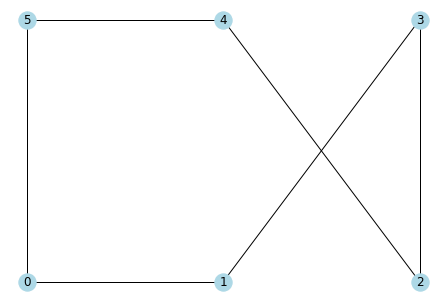
Let us give a direction to this path, say, 0-1-3-2-4-5-0.
We can try to uncross the edge 1-3 with 2-4 and see if this gives a better solution.
By uncrossing two edges $e_1$ and $e_2$ we mean to remove the edges and introduce instead $(h(e_1), h(e_2))$ and $(t(e_1), t(e_2)$, where $h(e)$ is the `head` of the edge (the first node in the edge) and $t(e)$ is the `tail` (the second node).
Of course, `head` and `tail` only make sense when there is a direction, but we gave one to the path.
By 'uncrossing' the pair of edges 1-3 and 2-4, we get 1-2 and 3-4, which yields the following path.
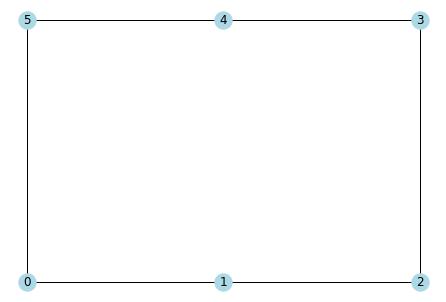
**Note** we had two options to replace 1-3 and 2-4. The uncrossing gave 1-2 and 3-4, but we could also replace them with 1-4 and 3-2. Doing this yields
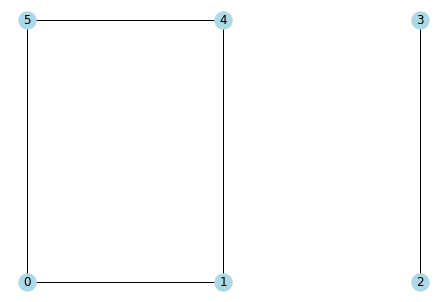
As you can see, this disconnects the path and is not a valid operation. This is the reason why we need to orient the path and define the uncrossing as above. If we do not orient the path, in principle, we have no idea how to perform the uncrossing.

**Your task**

Your task is to implement the heuristic. You should get the solution with `model.getBestSol()` and extract the (directed) edges in the path from the solution. Then, loop over every pair of non-adjacent edges (i.e. edges that do not share vertices) and check if uncrossing them gives a better solution. When you find an uncrossing that yields a better solution, create a new solution with `model.createSol()` and set it to the new solution. Then add it to SCIP and return.

**Hints**
* To build the (directed) edges of the path, it could be useful to build an adjacency list, i.e., for each node $i$, store the nodes that $i$ is connected to in the path. Then you can traverse the path and this traversal can provide a direction of the edges.
* Since you know that the solution is feasible, you can directly add it without checking for feasibility. For this, you can use `model.addSol()`
Assume the uncrossing of $e_1$ and $e_2$ gives the edges $f_1$ and $f_2$.
* To check that the uncrossing yields a better solution, notice that the new solution value is the old solution value minus the costs of $e_1$ and $e_2$, plus the costs of $f_1$ and $f_2$.
Therefore, the new solution value is better (smaller) than the old solution value if and only if
$c_{f_1} + c_{f_2} < c_{e_1} + c_{e_2}$
* If one of the variables $x_{f_i}$ is fixed to 0 or one of the variables $x_{e_i}$ is fixed to 1, then the uncrossing cannot be performed



In [ ]:
# Heuristic
class TwoOpt(Heur):

    def __init__(self, costs, vars_dict):
        self.data = {}
        self.data['costs'] = costs
        self.data['vars'] = vars_dict
        self.data['primalbound'] = 0.0
        
    # given an edge = (a, b), returns edge in model, i.e. (a,b) if a < b or (b,a) if b > a
    def real_edge(self, edge):
        assert edge[0] != edge[1]
        return tuple(sorted(edge))

    def heurexec(self, heurtiming, nodeinfeasible):

        # only run if we have a new solution
        primalbound = self.model.getPrimalbound()
        #print("calling 2opt primalbound and stored primal = ", primalbound, self.data['primalbound'])
        if self.model.isInfinity(primalbound) or primalbound == self.data['primalbound']:
            return {"result": SCIP_RESULT.DIDNOTRUN}

        self.data['primalbound'] = primalbound

        # add code here to implement the heuristic and if successful return {"result": SCIP_RESULT.FOUNDSOL}

        return {"result": SCIP_RESULT.DIDNOTFIND}

Now we can try again. We can see if our heuristic found a solution in the output. In the `mem/heur` the name of our heuristic will appear when it finds a solution.

In [ ]:
model, x = setupModel('tspdata/eil51.tsp')
model.redirectOutput()
model.optimize()